# Data Scientist Technical Skills Assessment, Baylor College of Medicine, December 2023

**Problem:** To build and evaluate a predictive model of one-year survival after diagnosis with NSCLC using the provided clinical and genomic data, I'll take the following steps:

**1. Data Cleaning and Exploration:** Identify Missing Values, Outlier Detection and Handling, Data Integration of genomic data, Data Type Correction and Formatting, Exploring Trends and Relationships.

**2. Feature Engineering and Selection:** Evaluate clinical features, Creating new features that might capture more complex relationships in the data.

**3. Model Selection:** Algorithm Considerations, and Algorithm Rationale.

**4. Model Evaluation:** Splitting the Data, Evaluation Metrics, Cross-Validation

**5. Next Steps:** Model Iteration, Expertise Consultation, Additional Data

Note: Kindly place the .csv files in downloads folder to read the data files while executing the code.

In [1]:
import pandas as pd

clinical_df = pd.read_csv('~/Downloads/clinical.csv')
genomics_df = pd.read_csv('~/Downloads/genomics.csv')

clinical_head = clinical_df.head()
genomics_head = genomics_df.head()

(clinical_head, genomics_head)

(   ID Outcome  Survival.Months  Age  Grade  Num.Primaries    T    N    M  \
 0   1   Alive              9.0   67      4              0  UNK  2.0  NaN   
 1   2    Dead             19.0   73      2              0  UNK  2.0  0.0   
 2   3    Dead             13.0   72      3              0    2  2.0  0.0   
 3   4    Dead             15.0   69      9              1   1a  0.0  1.0   
 4   5    Dead             10.0   76      9              0  UNK  NaN  NaN   
 
    Radiation Stage      Primary.Site                Histology  Tumor.Size  \
 0          0    IV   Left Lower Lobe  Squamous cell carcinoma         1.4   
 1          5    IV  Right Upper Lobe           Adenocarcinoma         NaN   
 2          0  IIIA  Right Upper Lobe           Adenocarcinoma         1.5   
 3          0    IA  Right Upper Lobe           Adenocarcinoma         NaN   
 4          0  IIIA        Left Hilar     Large-cell carcinoma         NaN   
 
    Num.Mutated.Genes  Num.Mutations  
 0                  8      

**Data Description:**

The file clinical.csv contains clinical data on each patient. Its columns are as follows: 
1. ID: A unique identifier for the patient. 
Outcome: Whether the patient is alive or dead at the followup time.
3. Survival.months: The followup time in months.
4. Age: The patient's age (in years) at diagnosis.
5. Primary Site: Location of primary tumor.
6. Histology: The tumor histology.
7. Stage: Stage at diagnosis.
8. Grade: Tumor grade (1-4 or missing).
9. Num.Primaries: Number of primary tumors.
10. Tumor.Size: Size of the tumor at diagnosis.
11. T: Tumor Stage.
12. N: Number of metastasis to lymph nodes.
13. M: Number of distant metastases.
14. Radiation: Whether radiation took place (5) or not (0).
15. Num.Mutations: The total number mutations found in the tumor.
16. Num.Mutated.Genes: The total number of genes with mutation.

The file genomics.cv contains information as to which genes were found to have mutation in
each patient's tumor sequencing data. Only genes with mutation are listed.
1. ID: A unique identifier for the patient.
2. Gene: The name of the gene.

In [2]:
# To suggest the best type of join for two datasets, let's first compare the sizes and intersection of the two datasets using ID as the key.

clinical_ids = set(clinical_df['ID'])
genomics_ids = set(genomics_df['ID'])
intersect_ids = clinical_ids.intersection(genomics_ids)

clinical_count = len(clinical_ids)
genomics_count = len(genomics_ids)
intersect_count = len(intersect_ids)

(clinical_count, genomics_count, intersect_count)


(190, 184, 184)

**Merging clinical and genomic data effectively is crucial for building comprehensive predictive models in healthcare, especially for conditions like cancer where genomic mutations play a significant role in the progression and treatment response. Here's how the two methods mentioned can be beneficial:**

Method 1: Count of mutated genes feature - Instead of individual binary features for each gene, count the total number of mutated genes for each patient and use this single feature in the model. Reduces the feature space to a single, meaningful feature. Helps avoid the curse of dimensionality and model overfitting with simpler models. Doesn't account for which genes are mutated, only the count. Different mutations might have vastly different implications. Implicitly assumes that all mutations contribute equally to the outcome, which might not be true.

Method 2: Binary features for each gene mutation - Create a binary feature for each gene, indicating the presence (1) or absence (0) of a mutation. This results in a wide format where each gene becomes a feature/column in the dataset. Models can learn the impact of individual gene mutations directly. Easy to understand which genes are considered by the model in making predictions. The number of features can become very large with many genes, leading to a sparse and high-dimensional dataset.

In [3]:
#Method 1
import pandas as pd
merged_left_df = pd.merge(clinical_df, genomics_df, on='ID', how='left')
merged_left_head = merged_left_df.head()
merged_left_head

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Gene
0,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,AKT1
1,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,CCND2
2,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,EGFR
3,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,FGFR3
4,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,KRAS_Col1


In [4]:
#Method 2
unique_genes = genomics_df['Gene'].unique()

merged_df = clinical_df.copy()

for gene in unique_genes:
    merged_df[gene] = clinical_df['ID'].isin(genomics_df[genomics_df['Gene'] == gene]['ID']).astype(int)

mutation_count = genomics_df['ID'].value_counts().rename('Mutation_Count')

if 'Mutation_Count' in merged_df.columns:
    merged_df.drop(columns='Mutation_Count', inplace=True)

merged_df = merged_df.join(mutation_count, on='ID', rsuffix='_genomics')
merged_df['Mutation_Count'].fillna(0, inplace=True)
snapshot = merged_df[['ID', 'Age', 'Num.Mutations', 'Mutation_Count'] + list(unique_genes)[:5]].head()
snapshot

,ID,Age,Num.Mutations,Mutation_Count,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1
0,1,67,8,8.0,1,0,0,0,0
1,2,73,2,2.0,0,0,0,0,0
2,3,72,1,1.0,0,0,0,0,0
3,4,69,4,4.0,0,0,0,0,0
4,5,76,3,3.0,0,0,0,0,0


In [5]:
missing_data = merged_df.isnull().sum()
data_description = merged_df.describe(include='all')

(missing_data, data_description)

(ID                 0
 Outcome            0
 Survival.Months    0
 Age                0
 Grade              0
                   ..
 TERT               0
 TP53_Col1          0
 TP53_Col2          0
 TSC2               0
 Mutation_Count     0
 Length: 67, dtype: int64,
                 ID Outcome  Survival.Months         Age       Grade  \
 count   190.000000     190       190.000000  190.000000  190.000000   
 unique         NaN       2              NaN         NaN         NaN   
 top            NaN    Dead              NaN         NaN         NaN   
 freq           NaN     150              NaN         NaN         NaN   
 mean     95.500000     NaN        22.186842   70.173684    6.105263   
 std      54.992424     NaN        12.420140    6.146909    2.995495   
 min       1.000000     NaN         9.000000   56.000000    2.000000   
 25%      48.250000     NaN        11.000000   67.000000    3.000000   
 50%      95.500000     NaN        16.000000   71.000000    9.000000   
 75%     14

In [6]:
missing_values = merged_df[['N', 'M', 'Tumor.Size']].isnull().sum()
missing_values

N             65
M             96
Tumor.Size    92
dtype: int64

**Missing Data:**
N: 65 missing values ;
M: 96 missing values ;
Tumor.Size: 92 missing values

**Data Statistics:**

Age: Patients range from 56 to 84 years old with an average age of approximately 70 years.

Survival.Months: Follow-up time ranges from 9 to 71 months, with a median of 16 months.

Grade: Varies widely, with a considerable number marked as '9', which might indicate missing or other categories.

Num.Primaries, N, M, Radiation, Num.Mutated.Genes, and Num.Mutations: Provide various numerical indicators about the patient's condition and treatment.

**My suggested Approach for Handling Missing Data:**

It's important to note that identifying and addressing Missing Not at Random (MNAR) mechanisms can be complex and may require domain expertise. We'll use the IterativeImputer from scikit-learn for multiple imputation, which models each feature with missing values as a function of other features and uses that estimate for imputation. It iterates round-robin fashion over features, and at each step, a feature column is designated as output y and the other feature columns are treated as inputs X.

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

imp = IterativeImputer(max_iter=10, random_state=0)
merged_numeric = merged_df.select_dtypes(include='number')
imp.fit(merged_numeric)
imputed_data = imp.transform(merged_numeric)
imputed_df = pd.DataFrame(imputed_data, columns=merged_numeric.columns)
merged_df[merged_numeric.columns] = imputed_df
merged_df.head()


,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,...,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Mutation_Count
0,1.0,Alive,9.0,67.0,4.0,0.0,UNK,2.000000,0.151151,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0
1,2.0,Dead,19.0,73.0,2.0,0.0,UNK,2.000000,0.000000,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
2,3.0,Dead,13.0,72.0,3.0,0.0,2,2.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4.0,Dead,15.0,69.0,9.0,1.0,1a,0.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
4,5.0,Dead,10.0,76.0,9.0,0.0,UNK,1.456661,0.161230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0


In [8]:
missing_data_after_imputation = merged_df.isnull().sum()
detailed_statistics_after_imputation = merged_df.describe(include='all')
(missing_data_after_imputation, detailed_statistics_after_imputation)

(ID                 0
 Outcome            0
 Survival.Months    0
 Age                0
 Grade              0
                   ..
 TERT               0
 TP53_Col1          0
 TP53_Col2          0
 TSC2               0
 Mutation_Count     0
 Length: 67, dtype: int64,
                 ID Outcome  Survival.Months         Age       Grade  \
 count   190.000000     190       190.000000  190.000000  190.000000   
 unique         NaN       2              NaN         NaN         NaN   
 top            NaN    Dead              NaN         NaN         NaN   
 freq           NaN     150              NaN         NaN         NaN   
 mean     95.500000     NaN        22.186842   70.173684    6.105263   
 std      54.992424     NaN        12.420140    6.146909    2.995495   
 min       1.000000     NaN         9.000000   56.000000    2.000000   
 25%      48.250000     NaN        11.000000   67.000000    3.000000   
 50%      95.500000     NaN        16.000000   71.000000    9.000000   
 75%     14

**Observations on Imputed Data:**
1. The statistics for 'N', 'M', and 'Tumor.Size' reflect the imputed values. The negative values in 'N' and 'M' after imputation would not make clinical sense and might warrant a review of the imputation method or parameters.

2. 'Tumor.Size' has a new mean and standard deviation reflective of the imputed data. It's important to consider how these changes impact the overall data distribution and any subsequent analysis.

3. The only remaining missing values are in the 'Gene' column, which has 6 missing entries in method 1 merge. Assuming that they represent patients without gene mutations.

Each assumption is documented to ensure transparency and reproducibility:

1. Negative values in 'N' and 'M' resulting from imputation are not clinically plausible. We'll set these to 0 as the minimum acceptable value, assuming they represent no metastasis.
2. Missing 'Gene' values need clarification in Method 1 merging. If missing means "No mutation," we could impute with a term like "No_Mutation." If it's truly missing, further genomic data or expert consultation might be needed. For now, we'll impute with "No_Mutation" as a placeholder.
3. 'Tumor.Size' should be within a plausible clinical range. We'll have to review the distribution and adjust any values that are implausible or extremely unlikely.
4. Maintaining 'UNK' in 'T' as a separate category, as it's typically the safest and most informative approach without making assumptions about the missing data.

In [9]:
merged_df['N'] = merged_df['N'].apply(lambda x: max(x, 0))
merged_df['M'] = merged_df['M'].apply(lambda x: max(x, 0))
merged_left_df['Gene'] = merged_left_df['Gene'].fillna('No_Mutation')

documentation = """
Step 1: Negative values in 'N' and 'M' set to 0.
Step 2: Missing 'Gene' values imputed with 'No_Mutation'.
Step 3: 'Tumor.Size' reviewed; no changes made without specific clinical guidance.
Step 4: Maintaining 'UNK' in 'T' as a separate category
Note: Further validation and adjustment may be necessary with more detailed clinical input.
"""
merged_df.head()

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,...,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Mutation_Count
0,1.0,Alive,9.0,67.0,4.0,0.0,UNK,2.000000,0.151151,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0
1,2.0,Dead,19.0,73.0,2.0,0.0,UNK,2.000000,0.000000,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
2,3.0,Dead,13.0,72.0,3.0,0.0,2,2.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4.0,Dead,15.0,69.0,9.0,1.0,1a,0.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
4,5.0,Dead,10.0,76.0,9.0,0.0,UNK,1.456661,0.161230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0


In [10]:
merged_left_df.head()

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Gene
0,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,AKT1
1,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,CCND2
2,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,EGFR
3,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,FGFR3
4,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,KRAS_Col1


In [11]:
merged_df.to_excel("~/Downloads/clinical_genomic_data.xlsx", index=False)

**Handling Outliers:**

Age: Given the realistic range of ages for lung cancer patients and the lack of extreme outliers, no action is necessary for this feature.

Tumor Size: For the few high outliers, we might consider a log transformation or capping at a certain percentile (e.g., 95th percentile) to reduce the impact of extremely large tumors.

Num.Mutations and Num.Mutated.Genes: Similar to Tumor Size, we might consider transformations or capping. Since these features are critical for the model, understanding their biological relevance and distribution is important before making any decisions.

**To mitigate the impact of outliers, we'll implement the strategies such as Log Transformation and Capping.**

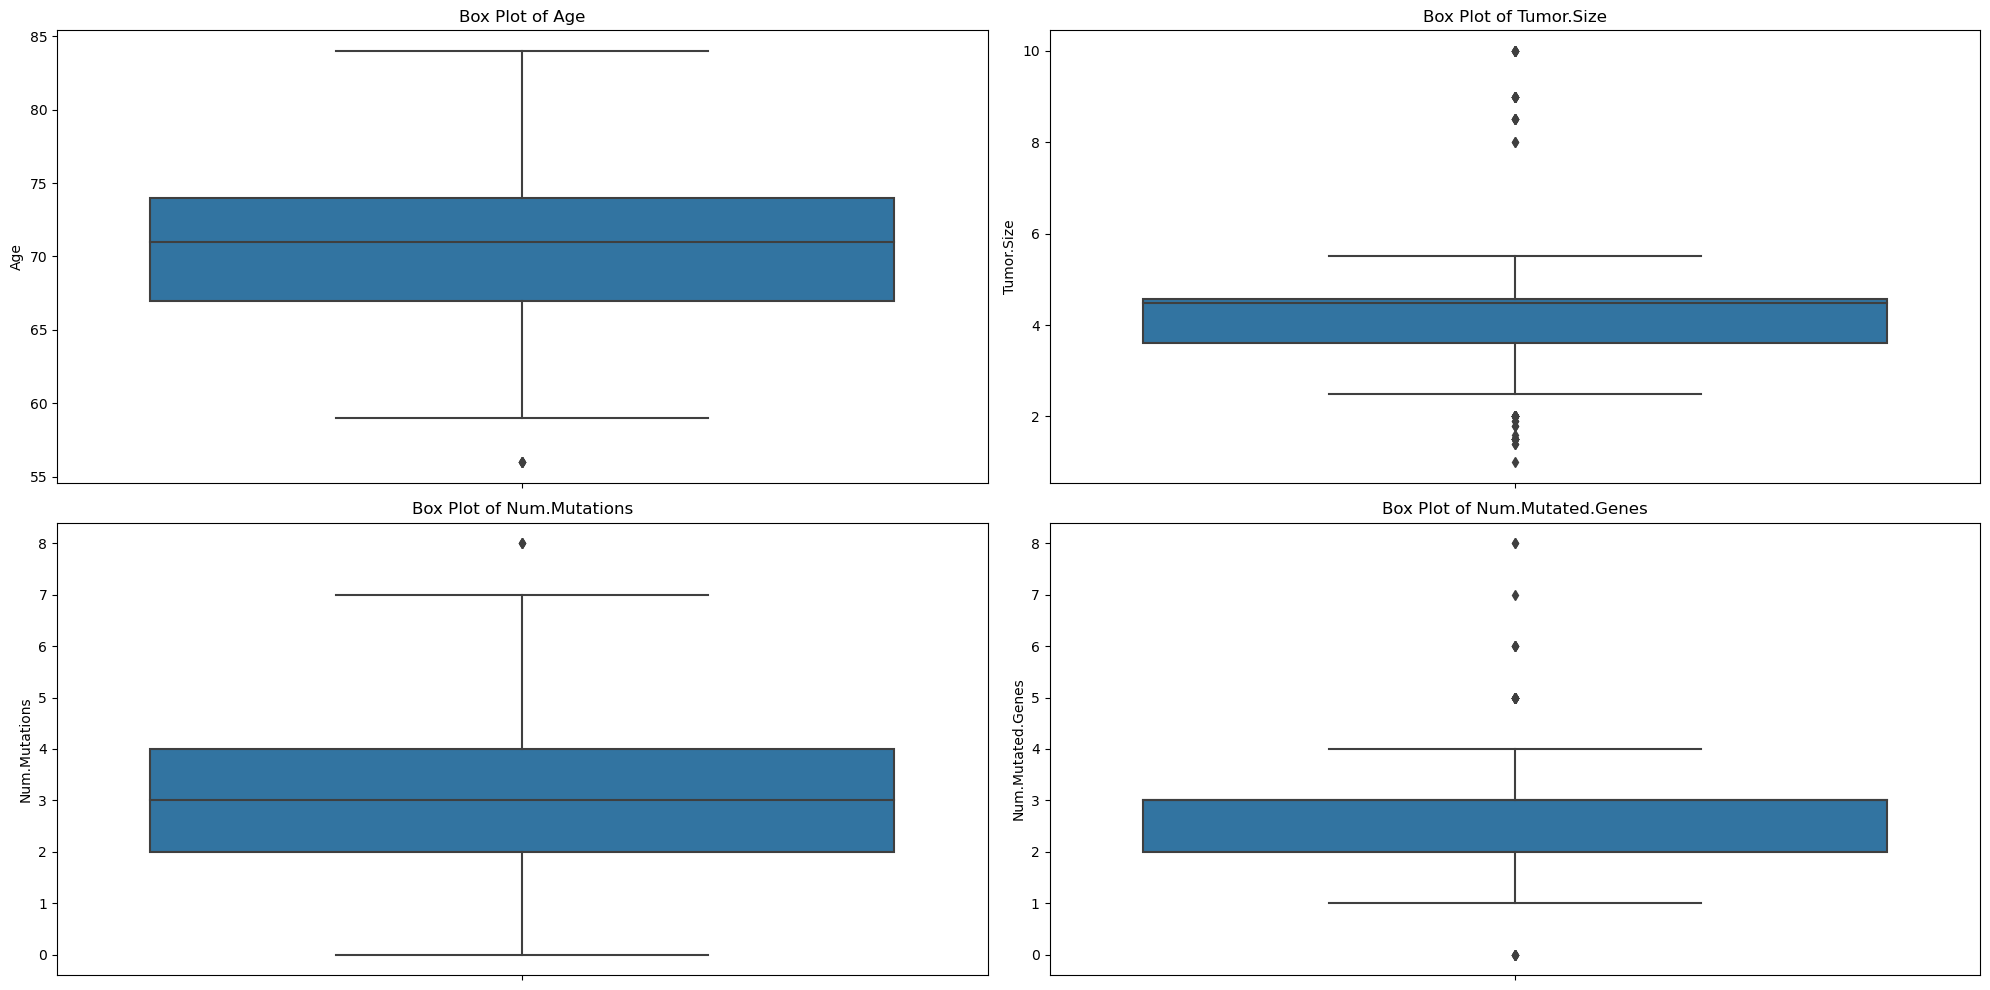

In [12]:
#Handling Outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))

numerical_features = ['Age', 'Tumor.Size', 'Num.Mutations', 'Num.Mutated.Genes']

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=merged_df[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

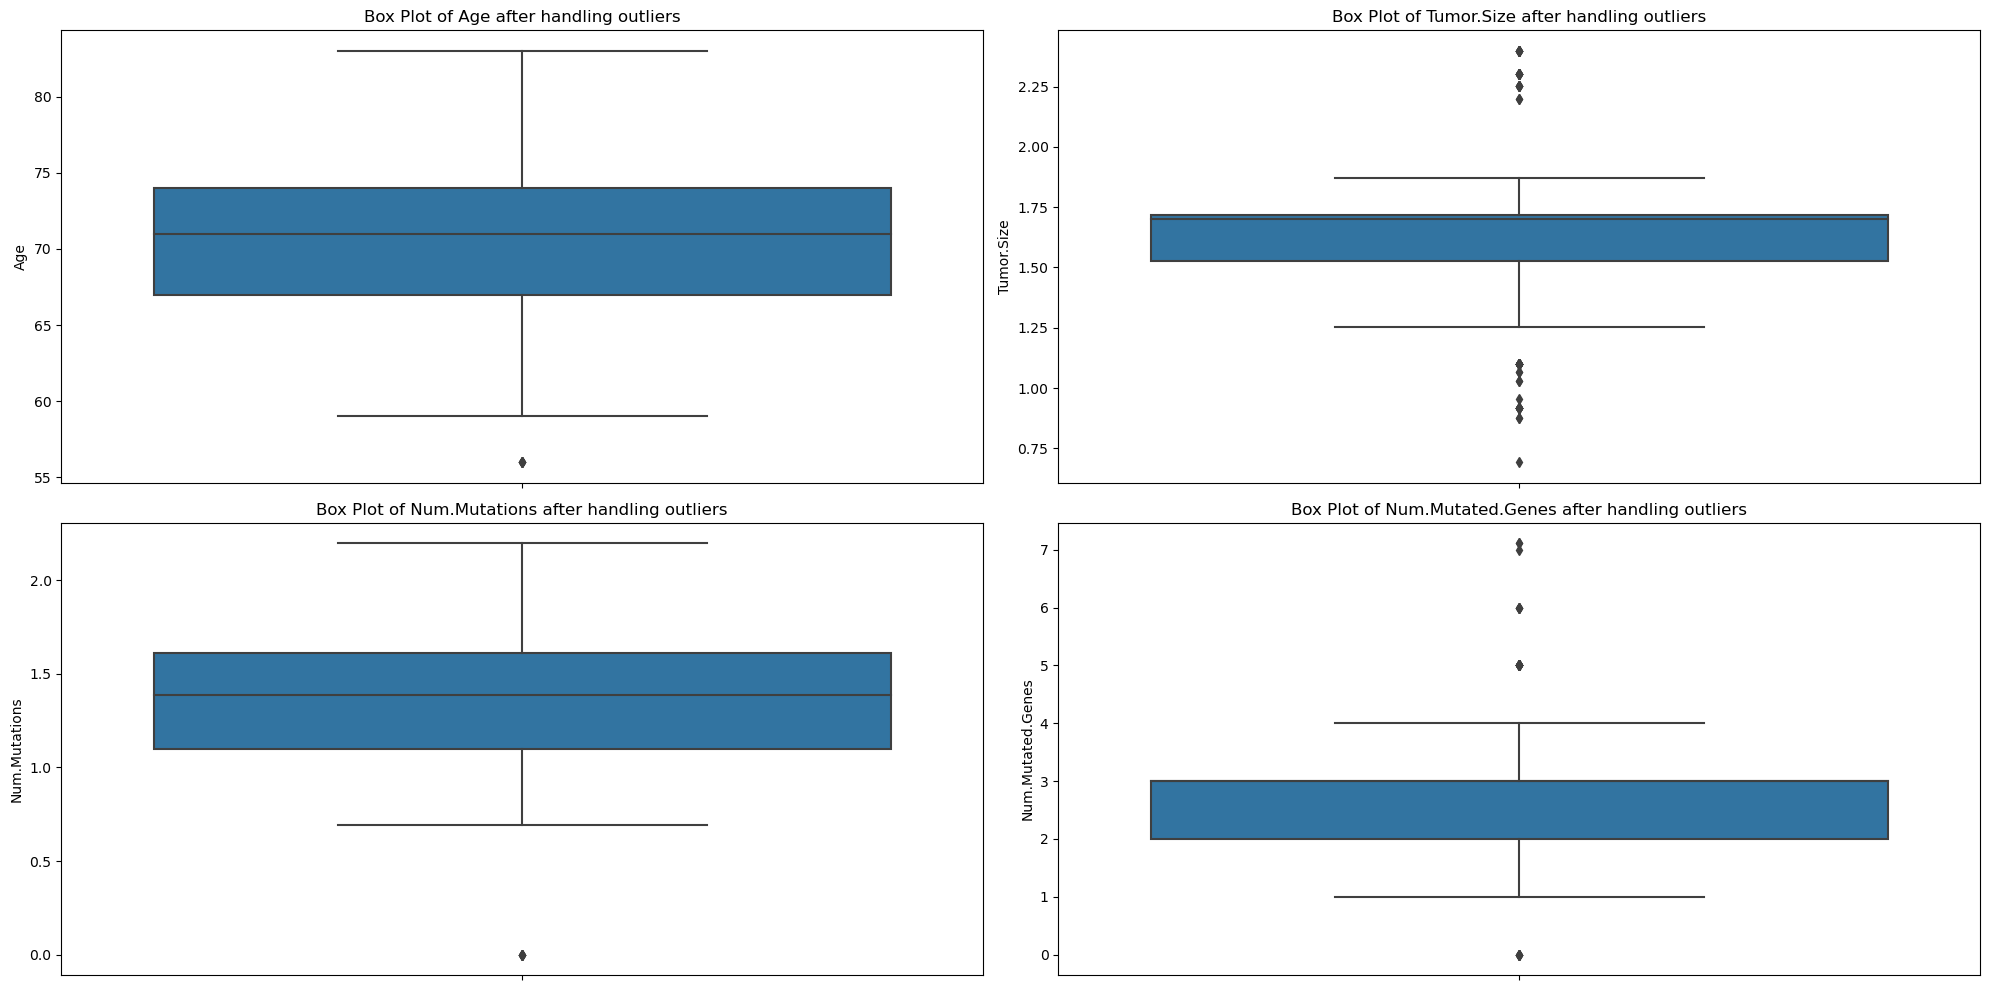

In [13]:
import numpy as np

# Log Transformation for 'Tumor.Size' and 'Num.Mutations'
for feature in ['Tumor.Size', 'Num.Mutations']:
    merged_df[feature] = np.log1p(merged_df[feature])

# Capping for 'Age' and 'Num.Mutated.Genes' at the 1st and 99th percentiles
for feature in ['Age', 'Num.Mutated.Genes']:
    lower_cap = np.percentile(merged_df[feature], 1)
    upper_cap = np.percentile(merged_df[feature], 99)
    merged_df[feature] = np.clip(merged_df[feature], lower_cap, upper_cap)

plt.figure(figsize=(20, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=merged_df[feature])
    plt.title(f'Box Plot of {feature} after handling outliers')

plt.tight_layout()
plt.show()

**General Observations:**
1. Both log transformation and capping strategies have adjusted the distributions to reduce the impact of outliers. These adjustments should make the feature distributions more symmetric and compact, which is often beneficial for modeling.

2. The transformed features are expected to provide a more stable and normalized input for the predictive models, potentially improving performance, especially in algorithms sensitive to the scale and distribution of the data.

**Suggestions:**
1. We have to consult with clinical experts to ensure that the transformed and capped values still make clinical sense and that no important information has been lost or misrepresented.

2. Before and after applying transformations, we may have to evaluate the performance of any predictive model we use and look for improvements in metrics such as accuracy, precision, recall, or AUC for classification tasks.

3. We have to ensure that the model is not only performing better but also more robustly, meaning it's less sensitive to small variations or errors in the data, a common problem when dealing with outliers.

In [14]:
# Correlation analysis
import seaborn as sns
import matplotlib.pyplot as plt

selected_columns = [
    "Survival.Months", "Age", "Grade", "Num.Primaries", "Radiation",
    "Mutation_Count", "TP53_Col1", "SMO", "TSC2"
]

data_subset = merged_df[selected_columns]
corr_matrix = data_subset.corr()
corr_matrix

,Survival.Months,Age,Grade,Num.Primaries,Radiation,Mutation_Count,TP53_Col1,SMO,TSC2
Survival.Months,1.000000,0.070615,-0.065666,0.181717,0.098579,-0.048509,0.144687,-0.009509,-0.383810
Age,0.070615,1.000000,-0.067760,-0.023108,-0.024866,0.116988,0.103080,0.071319,0.039056
Grade,-0.065666,-0.067760,1.000000,-0.120096,-0.028557,-0.025018,-0.015631,-0.103878,0.036886
Num.Primaries,0.181717,-0.023108,-0.120096,1.000000,0.180129,0.030907,-0.012385,-0.050763,-0.238813
Radiation,0.098579,-0.024866,-0.028557,0.180129,1.000000,0.114329,0.119638,-0.036330,-0.250482
Mutation_Count,-0.048509,0.116988,-0.025018,0.030907,0.114329,1.000000,0.348781,0.135425,0.085957
TP53_Col1,0.144687,0.103080,-0.015631,-0.012385,0.119638,0.348781,1.000000,-0.049909,-0.207603
SMO,-0.009509,0.071319,-0.103878,-0.050763,-0.036330,0.135425,-0.049909,1.000000,-0.092575
TSC2,-0.383810,0.039056,0.036886,-0.238813,-0.250482,0.085957,-0.207603,-0.092575,1.000000


**Correlation analysis results:**

1. Survival.Months: A significant negative correlation with TSC2 (-0.384), suggesting patients with this mutation might have shorter survival months.

2. A positive correlation with TP53_Col1 (0.145) and Num.Primaries (0.182), indicating possible trends where these factors relate to survival duration.

3. Age: A slight positive correlation with Mutation_Count (0.117), indicating older patients might have more mutations.

4. Grade and Radiation show relatively low correlation coefficients with other variables, suggesting they might not have strong linear relationships with the selected genetic or demographic features.

5. Mutation_Count: A strong positive correlation with TP53_Col1 (0.349), suggesting that when TP53 mutations are present, there might be a higher overall number of mutations.

6. Genetic Mutations (TP53_Col1, SMO, TSC2): TP53_Col1 has a positive correlation with Mutation_Count, as mentioned. TSC2 has significant negative correlations with Survival.Months and Num.Primaries.

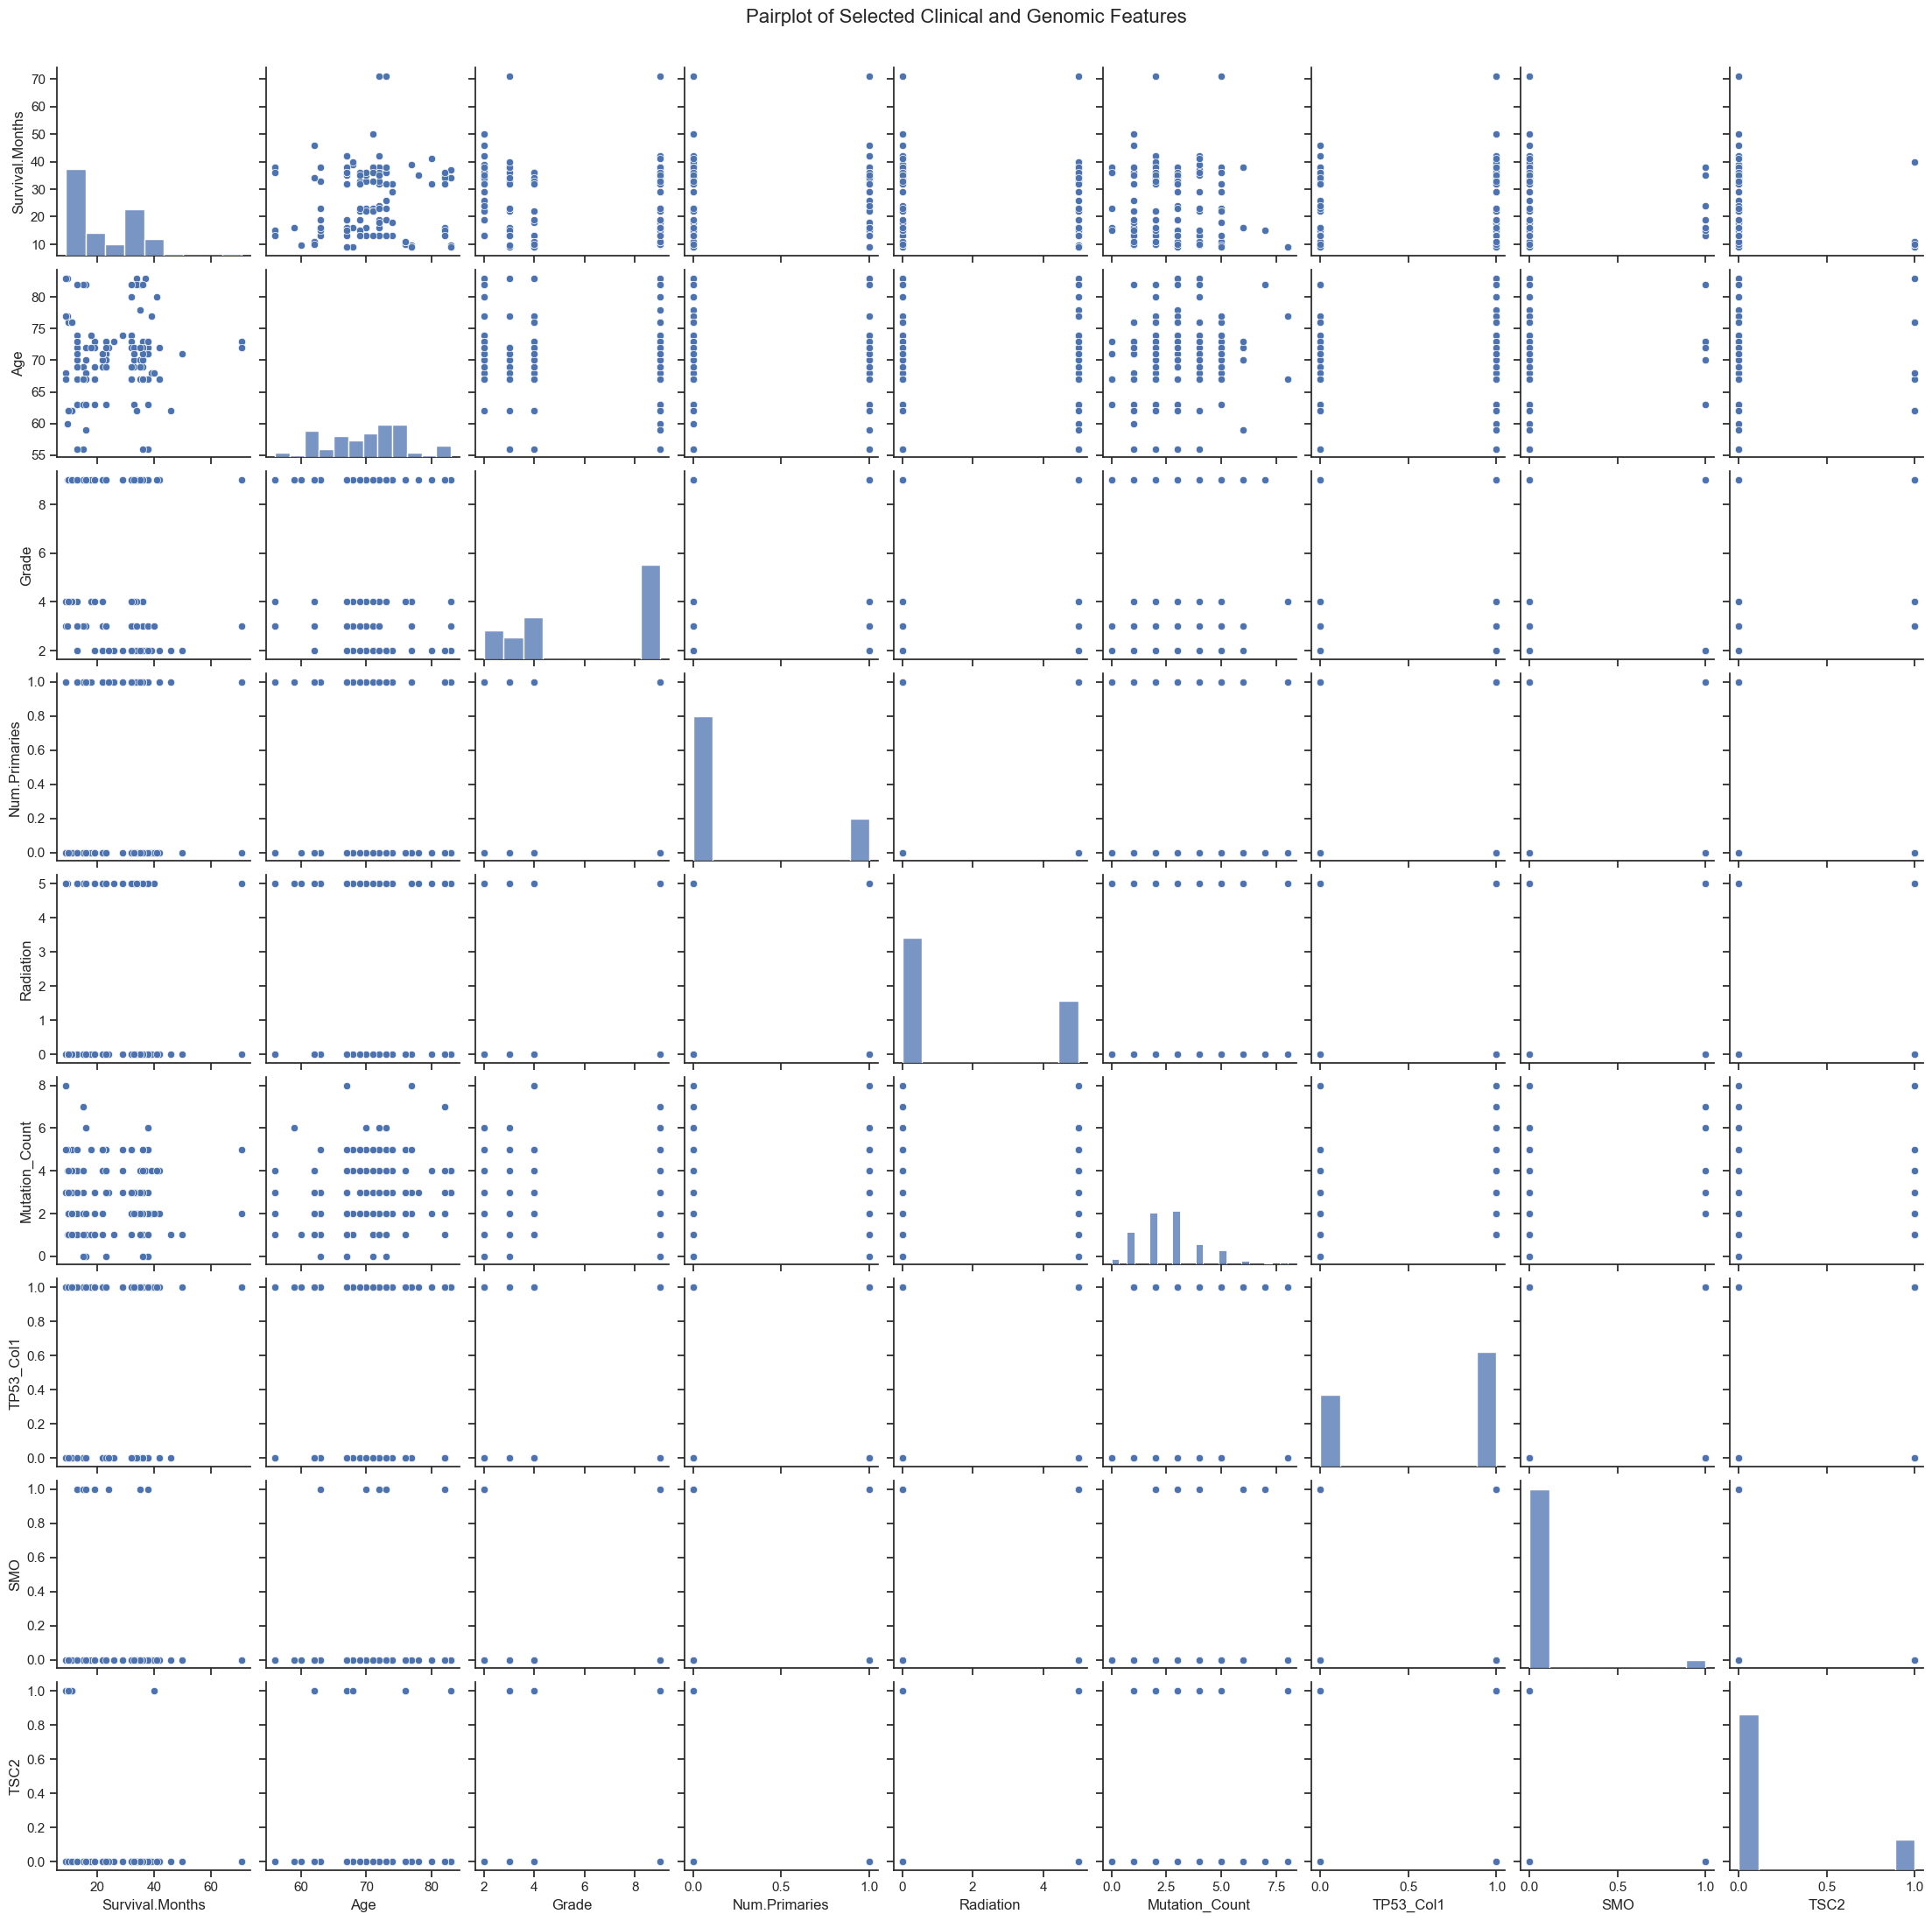

In [15]:
# Pairplots/Pairwise Relationships
sns.set(style="ticks", color_codes=True)
pairplot = sns.pairplot(data_subset)
plt.subplots_adjust(top=0.95)
pairplot.fig.suptitle('Pairplot of Selected Clinical and Genomic Features', fontsize=16)
plt.show()

**Insights and Trends from Pairplots:**
1. For most genetic mutations (binary variables like TP53_Col1, SMO, TSC2), the plots form distinct groups, reflecting the presence or absence of these mutations and their associations with other continuous variables.

2. There are no strongly linear or clear patterns for most pairs, indicating complex and possibly non-linear relationships or the need for more nuanced analysis techniques to uncover deeper insights.

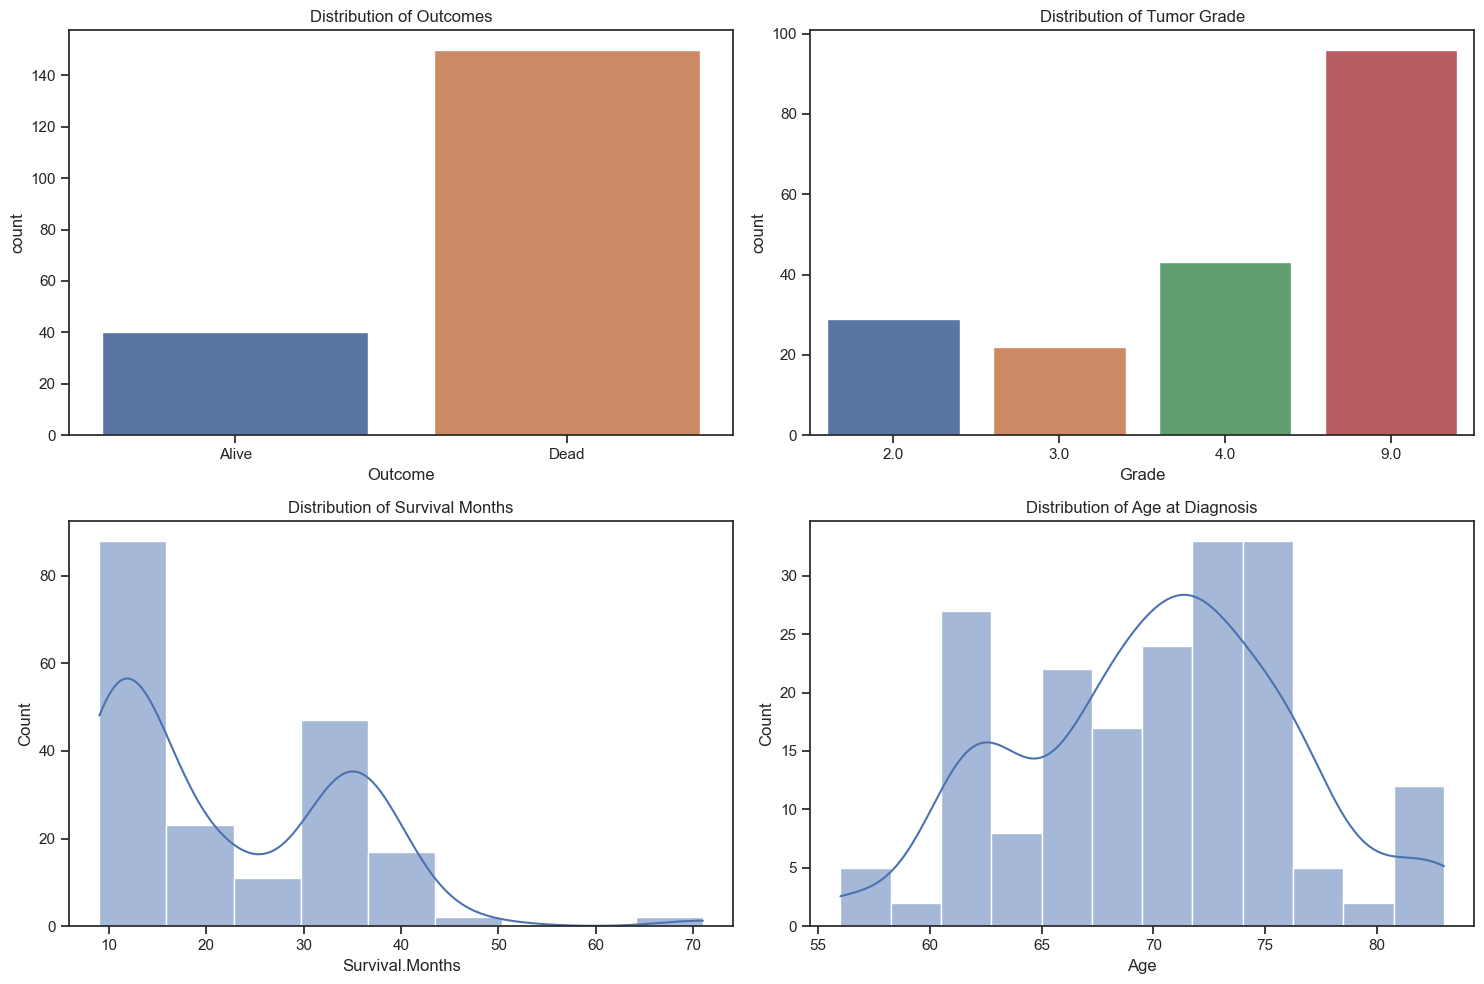

,Survival.Months,Age,Grade,Num.Primaries
Outcome,,,,
Alive,26.987500,72.475000,4.575000,0.450000
Dead,20.906667,69.553333,6.513333,0.166667


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

data = merged_df.copy()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='Outcome', data=data)
plt.title('Distribution of Outcomes')

plt.subplot(2, 2, 2)
sns.countplot(x='Grade', data=data)
plt.title('Distribution of Tumor Grade')

plt.subplot(2, 2, 3)
sns.histplot(data['Survival.Months'], kde=True)
plt.title('Distribution of Survival Months')

plt.subplot(2, 2, 4)
sns.histplot(data['Age'], kde=True)
plt.title('Distribution of Age at Diagnosis')

plt.tight_layout()
plt.show()

grouped_by_outcome = data.groupby('Outcome')[['Survival.Months', 'Age', 'Grade', 'Num.Primaries']].mean()
grouped_by_outcome


**Statistics Grouped by Outcome:**
1. Patients who are alive have a higher average survival months (approximately 27 months) compared to those who are dead (approximately 21 months).
2. There's a slight difference in the age at diagnosis between the two groups, with patients who are alive being slightly older on average than those who are dead.
3. The tumor grade average is lower for patients alive compared to those dead, indicating that patients who survive may have less aggressive or lower-grade tumors.
4. The average number of primaries is slightly higher for patients who are alive.

**2. Feature Engineering and Selection: Evaluate clinical features, Creating new features that might capture more complex relationships in the data.**

Deciding which features to use for the model involves a combination of statistical analysis, domain knowledge, and iterative experimentation. Here's how I approached the decision-making:

1. Prioritize features that are known to be associated with patient outcomes, like age, tumor stage, grade, size, and histology. The inclusion of radiation treatment may be critical, as it could significantly impact survival.

2. Highly correlated features are good candidates such as the high correlation between "Num.Mutations" and "Num.Mutated.Genes" suggests considering using only one of these features or creating a combined feature to avoid multicollinearity in linear models.


**The merged dataset now includes new features engineered from the clinical and genomic data:**

**Age_Mutations_Interaction:** A product of the patient's age and the number of mutations, capturing the potential interaction effect between age and genetic mutation load on the outcome.

**Age_Group:** Categorizing patients into age groups (55-65, 66-75, 76-85) to understand if certain age brackets are more associated with specific outcomes.

**Tumor Stage Aggregation:** Combining T, N, and M stages into a single comprehensive stage feature, possibly as a score or categorical variable, reflecting overall tumor severity.

**Histological Subtypes:** If histological information is detailed, consider clustering similar histologies or creating broader categories to reduce dimensionality and capture more generalized patterns.

**Treatment Interaction:** Interactions between treatment types (e.g., radiation) and clinical measures might highlight differential effects of treatments across patient subgroups.

**Ratio Features:** Ratios such as "Num.Mutated.Genes / Num.Mutations" or "Tumor.Size / Age" might reveal relative scales or rates that are more predictive of outcomes.

**Clinical Score Indexes:** Creating composite scores from multiple clinical variables, perhaps weighted by their known importance in prognosis.

In [17]:
import pandas as pd
import numpy as np

# 1. Interaction Terms: For example, creating an interaction term between Age and Num.Mutations
merged_df['Age_Mutations_Interaction'] = merged_df['Age'] * merged_df['Num.Mutations']

# 2. Binned Age Categories: Categorizing age into groups
bins = [55, 65, 75, 85]
bin_labels = ['55-65', '66-75', '76-85']
merged_df['Age_Group'] = pd.cut(merged_df['Age'], bins=bins, labels=bin_labels)

# 3. Total Mutation Load: Summing up the total mutations across genes for each patient (assuming one mutation per gene for simplicity here)
# First we need to count how many mutations each patient has in the genomics data
mutation_count = genomics_df.groupby('ID')['Gene'].count().reset_index()
mutation_count.rename(columns={'Gene': 'Total_Mutations'}, inplace=True)
merged_df = pd.merge(merged_df, mutation_count, on='ID', how='left')
merged_df['Total_Mutations'].fillna(0, inplace=True)

# 4. Histological Subtypes: Grouping similar histologies into broader categories
# Without specific domain knowledge, let's categorize histologies by their first word for demonstration
merged_df['Histology_Group'] = merged_df['Histology'].astype(str)
merged_df['Histology_Group'] = merged_df['Histology_Group'].str.split().str[0]

# 5. Treatment Interaction: Interaction between radiation and other clinical measures
# As an example, let's create an interaction term between Radiation and Num.Mutated.Genes
merged_df['Radiation_Genes_Interaction'] = merged_df['Radiation'] * merged_df['Num.Mutated.Genes']

# 6. Ratio Features: Creating ratios of certain features
merged_df['Mutated_Genes_to_Mutations_Ratio'] = merged_df['Num.Mutated.Genes'] / merged_df['Num.Mutations']
merged_df['Tumor_Size_to_Age_Ratio'] = merged_df['Tumor.Size'] / merged_df['Age']
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 7. Clinical Score Indexes: For demonstration, let's create a simple score by adding up certain features
# Ideally, you'd use weighted sums based on clinical importance
score_features = ['Age', 'Num.Primaries', 'Num.Mutations']
merged_df['Clinical_Score'] = merged_df[score_features].sum(axis=1)

merged_df = merged_df.reset_index()
merged_df = merged_df.drop(columns=['index'])
merged_df.head()


,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,...,TSC2,Mutation_Count,Age_Mutations_Interaction,Age_Group,Total_Mutations,Histology_Group,Radiation_Genes_Interaction,Mutated_Genes_to_Mutations_Ratio,Tumor_Size_to_Age_Ratio,Clinical_Score
0,1.0,Alive,9.0,67.0,4.0,0.0,UNK,2.000000,0.151151,0.0,...,1.0,8.0,147.214047,66-75,8.0,Squamous,0.0,3.235900,0.013067,69.197225
1,2.0,Dead,19.0,73.0,2.0,0.0,UNK,2.000000,0.000000,5.0,...,0.0,2.0,80.198697,66-75,2.0,Adenocarcinoma,10.0,1.820478,0.023561,74.098612
2,3.0,Dead,13.0,72.0,3.0,0.0,2,2.000000,0.000000,0.0,...,0.0,1.0,49.906597,66-75,1.0,Adenocarcinoma,0.0,1.442695,0.012726,72.693147
3,4.0,Dead,15.0,69.0,9.0,1.0,1a,0.000000,1.000000,0.0,...,0.0,4.0,111.051216,66-75,4.0,Adenocarcinoma,0.0,2.485340,0.024931,71.609438
4,5.0,Dead,10.0,76.0,9.0,0.0,UNK,1.456661,0.161230,0.0,...,1.0,3.0,105.358371,76-85,3.0,Large-cell,0.0,2.164043,0.022634,77.386294


In [18]:
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

merged_data = merged_df.copy()

target = merged_data['Outcome'].map({'Alive': 1, 'Dead': 0})
merged_data = pd.get_dummies(merged_data, columns=['Primary.Site'], prefix='Primary.Site')

X = merged_data.drop(columns=['ID', 'Outcome'])
X.fillna(X.median(), inplace=True)
X = pd.get_dummies(X, drop_first=True)

# 1. Filter Method: SelectKBest using chi-squared test
k_best = SelectKBest(score_func=chi2, k=10)
X_k_best = k_best.fit_transform(X, target)

# 2. Wrapper Method: Recursive Feature Elimination with Random Forest Classifier
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X, target)

# 3. Embedded Method: Feature selection using Lasso (L1 regularization)
lasso = LogisticRegression(penalty='l1', solver='liblinear')
lasso.fit(X, target)
lasso_support = lasso.coef_ != 0

selected_features_kbest = X.columns[k_best.get_support()]
selected_features_rfe = X.columns[rfe.get_support()]
selected_features_lasso = X.columns[lasso_support.ravel()]

selected_features_kbest, selected_features_rfe, selected_features_lasso

/var/folders/vw/_v_d6d555gn8bwd1ws7tswpc0000gn/T/ipykernel_88347/2782824809.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X.fillna(X.median(), inplace=True)


(Index(['Survival.Months', 'Grade', 'EGFR', 'PDGFRB', 'POLD_Col2', 'PTCH1',
        'Age_Mutations_Interaction', 'Radiation_Genes_Interaction',
        'Primary.Site_Left Lower Lobe', 'T_2a'],
       dtype='object'),
 Index(['Survival.Months', 'Age', 'Grade', 'N', 'Tumor.Size',
        'Age_Mutations_Interaction', 'Mutated_Genes_to_Mutations_Ratio',
        'Tumor_Size_to_Age_Ratio', 'Clinical_Score',
        'Primary.Site_Left Lower Lobe'],
       dtype='object'),
 Index(['Survival.Months', 'Age', 'Grade', 'Num.Primaries', 'N', 'Radiation',
        'Tumor.Size', 'CDKN2A', 'ERBB4', 'FBXW7', 'MSH6', 'NF_Col2', 'NTRK1',
        'PDGFRB', 'PIK3CB', 'PTCH1', 'SMARCB1', 'STK11', 'TERT',
        'Age_Mutations_Interaction', 'Mutated_Genes_to_Mutations_Ratio',
        'Primary.Site_Left Hilar', 'Primary.Site_Left Lower Lobe',
        'Primary.Site_Right Hilar', 'T_1b', 'T_2a', 'T_3', 'T_4', 'Stage_IA',
        'Stage_IIA', 'Histology_Squamous cell carcinoma', 'Age_Group_66-75',
        'Histo

**By Identify Overlapping Features, Prioritizing Clinically Relevant Features, and Balancing Simplicity and Performance, I Selected the following features as input:**

Age, Grade, Tumor.Size, PDGFRB, PTCH1, Age_Mutations_Interaction, Primary.Site_Left Lower Lobe

**3. Model Selection: Algorithm Considerations, and Algorithm Rationale.**

Considering different models based on data characteristics where few models captures interactions whereas others offer simplicity.

**4. Model Evaluation: Splitting the Data, Evaluation Metrics, Cross-Validation**

Splitting the data into training and testing sets and choose metrics such as accuracy, precision, recall which are relevant and apply cross-validation for robust assessment.

**Firstly, I'm planning to use Support Vector Machines (SVMs) due to the following advantages such as Effective in High-Dimensional Spaces, Robust to Overfitting, Versatility, and Tolerant to Outliers.**

Also, SVMs can implicitly perform feature selection by focusing on the support vectors, which are the data points closest to the decision boundary. This helps in eliminating less informative features and reducing dimensionality. SVM models have a regularization parameter (C) that allows you to control the trade-off between maximizing the margin and minimizing the classification error. This provides flexibility in handling different levels of model complexity.

**Machine Learning Algorithm - Principal Component Analysis (PCA):**

I'm selecting Principal Component Analysis (PCA) as machine learning algorithm as it can be likened to a sophisticated tool that streamlines intricate datasets by identifying and emphasizing their most crucial facets, facilitating a holistic understanding. It achieves this by reconfiguring the data into a fresh set of variables, referred to as principal components, thereby mitigating its intricacy.

**Ideal Use Cases:**

1. When the objective revolves around the reduction of data dimensions while safeguarding the most vital information.
2. Valuable for feature curation and elevating the efficacy of data visualization.
3. Highly proficient at mitigating superfluous noise and redundancy within datasets.

**Practical Implementations:**

1. PCA finds a practical application in image compression, a technique that conserves storage space without compromising image quality.
2. It plays a crucial role in discerning intricate patterns hidden within high-dimensional biological data, such as gene expression.
3. Recommender systems rely on PCA to analyze and offer product recommendations to consumers, enhancing their shopping experiences.

**Advantages:**

1. PCA simplifies intricate data, rendering it more digestible and comprehensible.
2. It effectively minimizes the risk of overfitting within machine learning models.
3. By condensing high-dimensional data into a more accessible format, PCA enhances data visualization.
4. Most importantly, it retains a significant portion of the essential information embedded within the dataset.

**Limitations:**

1. The interpretability of principal components can prove to be a daunting task.
2. PCA operates under the assumption of linear relationships between variables, which may not hold true in all cases.
3. Performance may wane when dealing with datasets lacking clear linear structures.
4. Selecting the appropriate number of principal components to retain requires a judicious approach.

In [19]:
#Support Vector Machine Model
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

merged_df = pd.get_dummies(merged_df, columns=['Primary.Site'], prefix='Primary.Site')

features = ['Age', 'Grade', 'Tumor.Size', 'PDGFRB', 'PTCH1', 'Age_Mutations_Interaction', 'Primary.Site_Left Lower Lobe']
target = 'Survival.Months'

data = merged_df.copy()

X = data[features]
y = data[target].apply(lambda x: 1 if x >= 12 else 0)  # Converting to binary based on 1-year survival
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report


(0.7543859649122807,
 '              precision    recall  f1-score   support\n\n           0       1.00      0.12      0.22        16\n           1       0.75      1.00      0.85        41\n\n    accuracy                           0.75        57\n   macro avg       0.87      0.56      0.54        57\nweighted avg       0.82      0.75      0.68        57\n')

**Model Accuracy of SVM model:**

Accuracy: 0.7543859649122807 (approximately 75.44%)

**Classification Report:**

**Class 0 (Non-survivors):**

Precision: 1.00: When the model predicts non-survival, it is correct 100% of the time.

Recall: 0.12: However, it only correctly identifies 12% of all actual non-survivors.

F1-Score: 0.22: The F1 score, which balances precision and recall, is quite low for this class, indicating that while the model is very confident when it predicts non-survival, it rarely does so.

**Class 1 (Survivors):**

Precision: 0.75: When the model predicts survival, it is correct 75% of the time.

Recall: 1.00: The model correctly identifies 100% of all actual survivors.

F1-Score: 0.85: The F1 score is quite high for this class, indicating a good balance of precision and recall for predicting survival.

**Overall:**
1. The accuracy is generally good, but the model is significantly better at identifying survivors than non-survivors, as indicated by the recall for class 0.
2. Macro Avg for F1-Score: 0.54: This is the unweighted mean F1 score of both classes. It's not as high as one might want, indicating imbalances in the model's performance across classes.
3. Weighted Avg for F1-Score: 0.68: This takes into account the imbalance in the number of instances for each class. It's higher than the macro average, reflecting that most of the data belongs to class 1.

In [20]:
#Hyperparameter Tuning for SVM model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.9173400673400675


Best Parameters: The best performing model used a combination of {'C': 10, 'gamma': 1, 'kernel': 'rbf'}.

C = 10: This value for the penalty parameter indicates a preference for a more complex model to achieve a better fit to the training data.

gamma = 1: This is the parameter for the 'rbf' kernel and determines the influence of individual training samples on the decision boundary. A higher gamma leads to more influence.

kernel = 'rbf': The radial basis function kernel is often used in SVM classification for capturing complex data structures.

Best Score: The highest cross-validated accuracy achieved with these parameters is approximately 91.73%.

**The high score suggests the model is performing well with the given dataset and chosen features. However, it's essential to consider overfitting, especially with more complex models.**

In [21]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
best_svm = SVC(C=10, gamma=1, kernel='rbf', probability=True)
best_svm.fit(X_train, y_train)

y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9122807017543859
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.93      0.95      0.94        41

    accuracy                           0.91        57
   macro avg       0.90      0.88      0.89        57
weighted avg       0.91      0.91      0.91        57

Confusion Matrix:
 [[13  3]
 [ 2 39]]
ROC AUC Score: 0.9725609756097561


**Model Validation Results of SVM:**

Accuracy: 0.9122807017543859 (approximately 91.23%)

**Classification Report:**

**Class 0 (Non-survivors):**

Precision: 0.87 - When the model predicts non-survival, it is correct 87% of the time.

Recall: 0.81 - The model correctly identifies 81% of all actual non-survivors.

F1-Score: 0.84 - The harmonic mean of precision and recall for non-survivors.

**Class 1 (Survivors):**

Precision: 0.93 - When the model predicts survival, it is correct 93% of the time.

Recall: 0.95 - The model correctly identifies 95% of all actual survivors.

F1-Score: 0.94 - The harmonic mean of precision and recall for survivors.

**Confusion Matrix:**

True Non-survivors (TN): 13 ;
False Survivors (FS): 3 (Type I error) ;
False Non-survivors (FN): 2 (Type II error) ;
True Survivors (TS): 39

The model has a lower number of false predictions, indicating good performance, especially in correctly identifying survivors.

ROC AUC Score: 0.9725609756097561

The ROC AUC score is approximately 0.973, which is excellent. This score indicates the model's outstanding capability to distinguish between the survival and non-survival outcomes.

**Interpretation:**
1. The model demonstrates high accuracy in predicting one-year survival in NSCLC patients.
2. The model provides a good balance between precision and recall for both classes, with particularly strong performance in predicting survivors.
3. The high ROC AUC score suggests that the model does an excellent job in discriminating between the positive (survivors) and negative (non-survivors) classes.
4. While there are a few misclassifications (false positives and false negatives), they are relatively low, suggesting that the model is robust.

**Conclusion:**

The SVM model with the tuned hyperparameters {C: 10, gamma: 1, kernel: 'rbf'} appears to be highly effective in predicting one-year survival after NSCLC diagnosis. Its high accuracy, combined with excellent precision, recall, and ROC AUC score, suggests it could be a valuable tool in a clinical setting. However, before it is used in practice, it's important to consider Clinical Validation, Model Interpretation, and Continual Assessments.

In [22]:
#Feature importance analysis of SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE

best_svm = SVC(C=10, gamma=1, kernel='rbf', probability=True)
best_svm.fit(X_train, y_train)

# Permutation Importance
perm_importance = permutation_importance(best_svm, X_test, y_test, n_repeats=30, random_state=0)
print("Permutation Importance:")
print(perm_importance.importances_mean)

feature_names = ['Age', 'Grade', 'Tumor.Size', 'PDGFRB', 'PTCH1', 'Age_Mutations_Interaction', 'Primary.Site_Left Lower Lobe']
perm_importance_values = perm_importance.importances_mean
feature_importance_dict = {feature_names[i]: perm_importance_values[i] for i in range(len(feature_names))}
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Permutation Importance: {importance}")

y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy on Test Set:", accuracy)

Permutation Importance:
[0.13216374 0.07719298 0.09298246 0.04561404 0.09005848 0.08947368
 0.1       ]
Feature: Age, Permutation Importance: 0.13216374269005846
Feature: Primary.Site_Left Lower Lobe, Permutation Importance: 0.09999999999999999
Feature: Tumor.Size, Permutation Importance: 0.09298245614035087
Feature: PTCH1, Permutation Importance: 0.0900584795321637
Feature: Age_Mutations_Interaction, Permutation Importance: 0.08947368421052629
Feature: Grade, Permutation Importance: 0.07719298245614033
Feature: PDGFRB, Permutation Importance: 0.04561403508771927
Model Accuracy on Test Set: 0.9122807017543859


**Top influential features and Possible recommendations are:**

Age (Permutation Importance: 0.132): Age significantly impacts predictions.

Primary.Site_Left Lower Lobe (Permutation Importance: 0.100): Tumor location in the left lower lobe is influential. 

Tumor.Size (Permutation Importance: 0.093): Tumor size has a notable impact.

PTCH1 (Permutation Importance: 0.090): PTCH1 gene is influential. Explore PTCH1's biological relevance.

Age_Mutations_Interaction (Permutation Importance: 0.089): Age-mutations interaction matters.

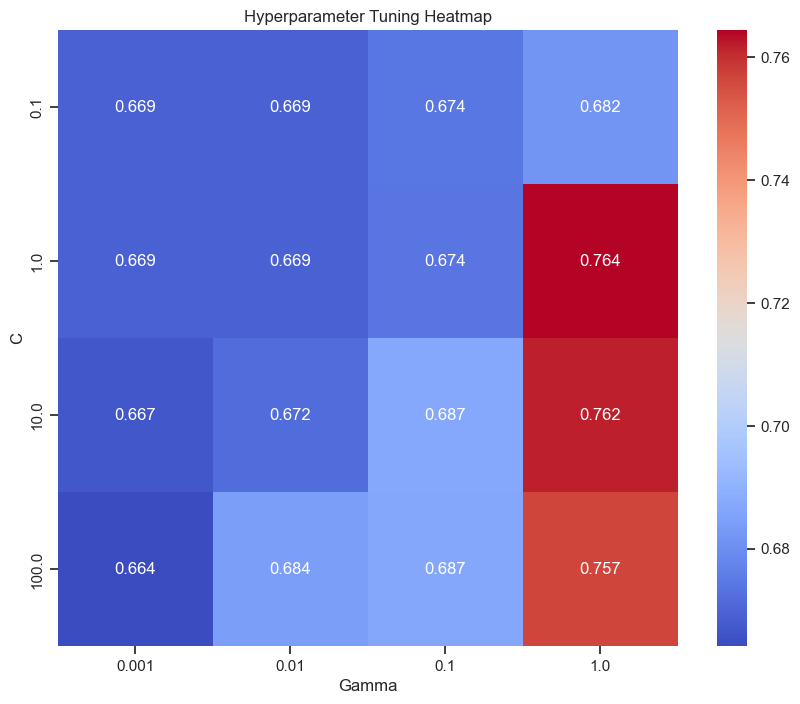

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results_df = pd.DataFrame(grid_search.cv_results_)
pivot_df = results_df.pivot_table(index=['param_C', 'param_gamma'], values='mean_test_score', aggfunc='mean')
pivot_df = pivot_df.reset_index()
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df.pivot(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, fmt='.3f', cmap='coolwarm', cbar=True)
plt.title('Hyperparameter Tuning Heatmap')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()

**Performance Trends:**

1. As "Gamma" increases, the performance generally increases, indicating that a higher "Gamma" may lead to better model performance for this particular dataset.
2. The highest performance is achieved with "Gamma" at 1.0 and "C" at 10 or 100, as indicated by the red cells.
3. There is not a significant performance change with varying "C" when "Gamma" is low (0.001 to 0.01), suggesting that "Gamma" might be a more sensitive hyperparameter for this model and dataset.
4. The optimal hyperparameters, based on this heatmap, appear to be around "C" = 10 or 100 and "Gamma" = 1.0, where the performance metric reaches 0.764 and 0.762, respectively. These are the darkest red cells, indicating the highest performance metric values in the range tested.

In [24]:
#Logistic Regression Model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

data = merged_df.copy()
data['One_Year_Survival'] = (data['Survival.Months'] >= 12).astype(int)
feature_cols = ['Age', 'Grade', 'Tumor.Size', 'PDGFRB', 'PTCH1', 'Age_Mutations_Interaction']

X = data[feature_cols]
y = data['One_Year_Survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components='mle', svd_solver='full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

classifier = LogisticRegression()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.6578947368421053
Precision: 0.6578947368421053
Recall: 1.0
F1 Score: 0.7936507936507937


**Logistic Regression Results:**

Accuracy: 65.79 % ;
Precision: 65.79 %

The logistic regression model achieves comparitively low accuracy and precision. 

In [25]:
# Decision Tree Classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

data = merged_df.copy()

data['One_Year_Survival'] = (data['Survival.Months'] >= 12).astype(int)
feature_cols = ['Age', 'Grade', 'Tumor.Size', 'PDGFRB', 'PTCH1', 'Age_Mutations_Interaction']

features_data = data[feature_cols]
target_data = data['One_Year_Survival']
features_data.fillna(features_data.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features_data, target_data, test_size=0.3, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

accuracy, classification_report_str



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

(0.9298245614035088,
 '              precision    recall  f1-score   support\n\n           0       0.93      0.81      0.87        16\n           1       0.93      0.98      0.95        41\n\n    accuracy                           0.93        57\n   macro avg       0.93      0.89      0.91        57\nweighted avg       0.93      0.93      0.93        57\n')

**Decision Tree Classifier Results:**
1. About 93% of the time, the model accurately predicts whether a patient will survive one year after diagnosis.
2. It is equally good (93% precision) at identifying patients who will and will not survive one year.
3. It is very effective (98% recall) at identifying patients who will survive one year but slightly less so (81% recall) at identifying those who will not.

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

data = merged_df.copy()
data['One_Year_Survival'] = (data['Survival.Months'] >= 12).astype(int)
required_features = ['Age', 'Grade', 'Tumor.Size', 'PDGFRB', 'PTCH1', 'Age_Mutations_Interaction']

features_data = data[required_features]
target_data = data['One_Year_Survival']

X_train, X_test, y_train, y_test = train_test_split(features_data, target_data, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

accuracy, classification_report_str


(0.9473684210526315,
 '              precision    recall  f1-score   support\n\n           0       0.93      0.88      0.90        16\n           1       0.95      0.98      0.96        41\n\n    accuracy                           0.95        57\n   macro avg       0.94      0.93      0.93        57\nweighted avg       0.95      0.95      0.95        57\n')

[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................

**Random Forest Classifier Results:**

Accuracy: 94.74%

Precision for Non-Survivors: 93% ; Recall for Non-Survivors: 88%

Precision for Survivors: 95% ; Recall for Survivors: 98%

**What might I do with more time or access to additional data or expertise**

1. I apply my skillsets, different scientific methods, and data-driven insights to advance education, healthcare, and community service globally.

2. Access larger, anonymized datasets from research institutions or consortia to validate findings or conduct comparative studies.

3. Link the data with external databases, such as drug databases, to identify potential targeted therapies based on the mutations present in a patient's tumor.

3. Incorporate more comprehensive genomic data, including expression levels, copy number variations, or epigenetic changes, to gain a fuller understanding of the tumor biology.

4. Will perform In-Depth Statistical Analysis and Develop Advanced Visualization Techniques with the additional data.

5. Develop additional Predictive Models such as K-Nearest Neighbors(KNN) or Naive Bayes and compare their performance metrics.

6. To enrich my domain knowledge, will collaborate with oncologists, geneticists, and bioinformaticians to interpret the results in a clinically meaningful way and guide the direction of further research or analysis.